## Collaborative Filterting on MovieLens Dataset¶

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [3]:
plt.style.use('ggplot')

The function below ensures that we seed all random generators with the same value to get reproducible results:

In [4]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [5]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

### Download Dataset

In [6]:
def try_download(url, download_path):
    archive_name = url.split('/')[-1]
    folder_name, _ = os.path.splitext(archive_name)
    
    try:
        r = urlopen(url)
    except URLError as e:
        print('Cannot download the data. Error: %s' % s)
        return 

    assert r.status == 200
    data = r.read()

    with zipfile.ZipFile(io.BytesIO(data)) as arch:
        arch.extractall(download_path)
        
    print('The archive is extracted into folder: %s' % download_path)

In [7]:
def read_data(path):
    files = {}
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
        elif filename.suffix == '.dat':
            if filename.stem == 'ratings':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
            else:
                columns = ['movieId', 'title', 'genres']
            data = pd.read_csv(filename, sep='::', names=columns, engine='python')
            files[filename.stem] = data
    return files['ratings'], files['movies']

The following archives from the [Grouplens repository](http://files.grouplens.org/datasets/movielens) can be downloaded and read with the functions defined above:

- ml-latest-small
- ml-1m
- ml-10m
- ml-20m

In [8]:
# pick any other dataset instead
archive_url = f'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
download_path = Path.cwd() / 'data' / 'movielens'

In [9]:
try_download(archive_url, download_path)

The archive is extracted into folder: /Users/mfts/Developer/Private/followmytv-recommendations/data/movielens


In [10]:
!ls -l $download_path

total 0
drwxr-xr-x  6 mfts  staff  192 Aug 22 19:05 ml-1m


In [11]:
# pick one of the available folders
ratings, movies = read_data(download_path / 'ml-1m')

### Data Preview

In [12]:
ratings.head()

userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

In [13]:
movies.head()

movieId                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

In [14]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [15]:
tabular_preview(ratings, movies)

movieId  110   260   480   589   593   608   1196  1198  1210  1270  1580  \
userId                                                                      
889       4.0   4.0   3.0   5.0   5.0   4.0   4.0   NaN   3.0   4.0   3.0   
1015      4.0   5.0   4.0   5.0   5.0   5.0   4.0   5.0   4.0   4.0   4.0   
1150      2.0   5.0   NaN   2.0   3.0   5.0   4.0   2.0   3.0   2.0   2.0   
1181      3.0   4.0   2.0   5.0   3.0   3.0   4.0   3.0   3.0   3.0   4.0   
1449      3.0   3.0   2.0   2.0   5.0   5.0   3.0   4.0   2.0   2.0   4.0   
1680      1.0   2.0   5.0   5.0   5.0   5.0   5.0   5.0   3.0   3.0   4.0   
1941      5.0   5.0   5.0   3.0   5.0   4.0   5.0   5.0   5.0   5.0   5.0   
1980      4.0   4.0   4.0   4.0   5.0   5.0   4.0   5.0   4.0   5.0   4.0   
2063      5.0   4.0   4.0   2.0   5.0   2.0   4.0   4.0   4.0   4.0   3.0   
2909      5.0   5.0   5.0   4.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
3618      3.0   4.0   4.0   3.0   5.0   4.0   3.0   4.0   3.0   4.0   3.0   
4169      4.0   5.0   5.0   4.0   5.0   5.0   5.0   5.0   5.0   4.0   4.0   
4277      5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   4.0   5.0   4.0   
4344      5.0   5.0   4.0   4.0   2.0   5.0   5.0   5.0   5.0   4.0   3.0   
5795      5.0   5.0   5.0   4.0   5.0   4.0   5.0   5.0   4.0   5.0   1.0   

movieId  2028  2571  2762  2858  
userId                           
889       3.0   5.0   NaN   2.0  
1015      5.0   5.0   5.0   4.0  
1150      2.0   1.0   2.0   4.0  
1181      4.0   5.0   4.0   3.0  
1449      3.0   4.0   4.0   4.0  
1680      5.0   3.0   5.0   5.0  
1941      5.0   3.0   5.0   1.0  
1980      5.0   5.0   5.0   5.0  
2063      2.0   5.0   4.0   5.0  
2909      5.0   4.0   5.0   5.0  
3618      3.0   3.0   4.0   4.0  
4169      5.0   4.0   5.0   5.0  
4277      5.0   5.0   5.0   5.0  
4344      2.0   5.0   5.0   5.0  
5795      5.0   1.0   2.0   5.0

### Dataset Preparation

In [16]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [17]:
(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 6040 users, 3706 movies
Dataset shape: (1000209, 2)
Target shape: (1000209,)


In [18]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [19]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [20]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[3808, 2234],
        [1388,  143],
        [4509,  849],
        [1016, 2393]])
tensor([[4.],
        [4.],
        [2.],
        [3.]])


### Embeddings

In [46]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, movies, users, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [35]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [ ]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

### Cyclical Learning Rate (CLR)

In [22]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [23]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [24]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [25]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

In [ ]:
plot_lr(triangular(250, 0.005))

In [ ]:
plot_lr(triangular(250, 0.005, 'triangular2'))

In [ ]:
plot_lr(triangular(250, 0.005, 'exp_range', gamma=0.999))

In [ ]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

### Training

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [27]:
minmax = ratings.rating.min().astype(float), ratings.rating.max().astype(float)
minmax

(1.0, 5.0)

In [47]:
net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [48]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/100] train: 0.8903 - val: 0.8226
loss improvement on epoch: 2
[002/100] train: 0.7970 - val: 0.8070
loss improvement on epoch: 3
[003/100] train: 0.7998 - val: 0.8011
loss improvement on epoch: 4
[004/100] train: 0.7588 - val: 0.7876
loss improvement on epoch: 5
[005/100] train: 0.7666 - val: 0.7863
loss improvement on epoch: 6
[006/100] train: 0.7293 - val: 0.7834
[007/100] train: 0.7425 - val: 0.7847
[008/100] train: 0.6974 - val: 0.7891
[009/100] train: 0.7096 - val: 0.7855
[010/100] train: 0.6544 - val: 0.7985
[011/100] train: 0.6700 - val: 0.7938
[012/100] train: 0.6137 - val: 0.8059
[013/100] train: 0.6346 - val: 0.8019
[014/100] train: 0.5817 - val: 0.8214
[015/100] train: 0.6060 - val: 0.8044
[016/100] train: 0.5555 - val: 0.8253
early stopping after epoch 016


### Metrics

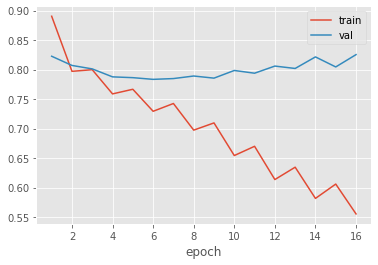

In [51]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

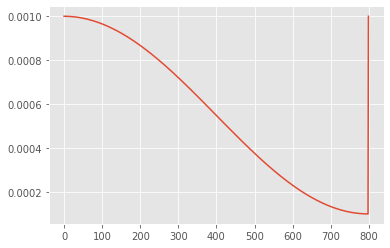

In [50]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [52]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [53]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 1], x_batch[:, 0], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [54]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8850


In [55]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)

### Visualization

In [56]:
from sklearn.decomposition import PCA

In [57]:
with open('best.weights', 'rb') as file:
    best_weights = pickle.load(file)
net.load_state_dict(best_weights)

<All keys matched successfully>

In [58]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

In [59]:
_, _, (user_id_map, movie_id_map) = create_dataset(ratings)
embed_to_original = {v: k for k, v in movie_id_map.items()}
popular_movies = ratings.groupby('movieId').movieId.count().sort_values(ascending=False).values[:1000]

In [60]:
embed = to_numpy(net.m.weight.data)
pca = PCA(n_components=5)
components = pca.fit(embed[popular_movies].T).components_
components.shape

(5, 1000)

In [61]:
components_df = pd.DataFrame(components.T, columns=[f'fc{i}' for i in range(pca.n_components_)])
movie_ids = [embed_to_original[idx] for idx in components_df.index]
meta = movies.set_index('movieId')
components_df['movie_id'] = movie_ids
components_df['title'] = meta.loc[movie_ids].title.values
components_df['genres'] = meta.loc[movie_ids].genres.values

In [62]:
components_df.sample(4)

fc0       fc1       fc2       fc3       fc4  movie_id  \
856 -0.022869 -0.016457 -0.015153  0.004386  0.069977      2528   
320 -0.011217 -0.045777  0.012139 -0.013084 -0.021810      1650   
477 -0.006573 -0.020375 -0.014803 -0.016464  0.010261      2442   
611 -0.045602 -0.064859 -0.010192  0.007057 -0.100027       750   

                                                 title  \
856                                 Logan's Run (1976)   
320                           Washington Square (1997)   
477                           Hilary and Jackie (1998)   
611  Dr. Strangelove or: How I Learned to Stop Worr...   

                      genres  
856  Action|Adventure|Sci-Fi  
320                    Drama  
477                    Drama  
611               Sci-Fi|War

In [63]:
def plot_components(components, component, ascending=False):
    fig, ax = plt.subplots(figsize=(18, 12))
    
    subset = components.sort_values(by=component, ascending=ascending).iloc[:12]
    columns = components_df.columns
    features = columns[columns.str.startswith('fc')].tolist()
    
    fc = subset[features]
    titles = ['\n'.join(wrap(t, width=10)) for t in subset.title]
    genres = subset.genres.str.replace('|', '\n')
    labels = [f'{t}\n\n{g}' for t, g in zip(titles, genres)]
    
    fc.plot(ax=ax, kind='bar')
    y_ticks = [f'{t:2.2f}' for t in ax.get_yticks()]
    ax.set_xticklabels(labels, rotation=0, fontsize=14)
    ax.set_yticklabels(y_ticks, fontsize=14)
    ax.legend(loc='best', fontsize=14)
    
    plot_title = f"Movies with {['highest', 'lowest'][ascending]} '{component}' component values" 
    ax.set_title(plot_title, fontsize=20)

/opt/anaconda3/envs/followmytv/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


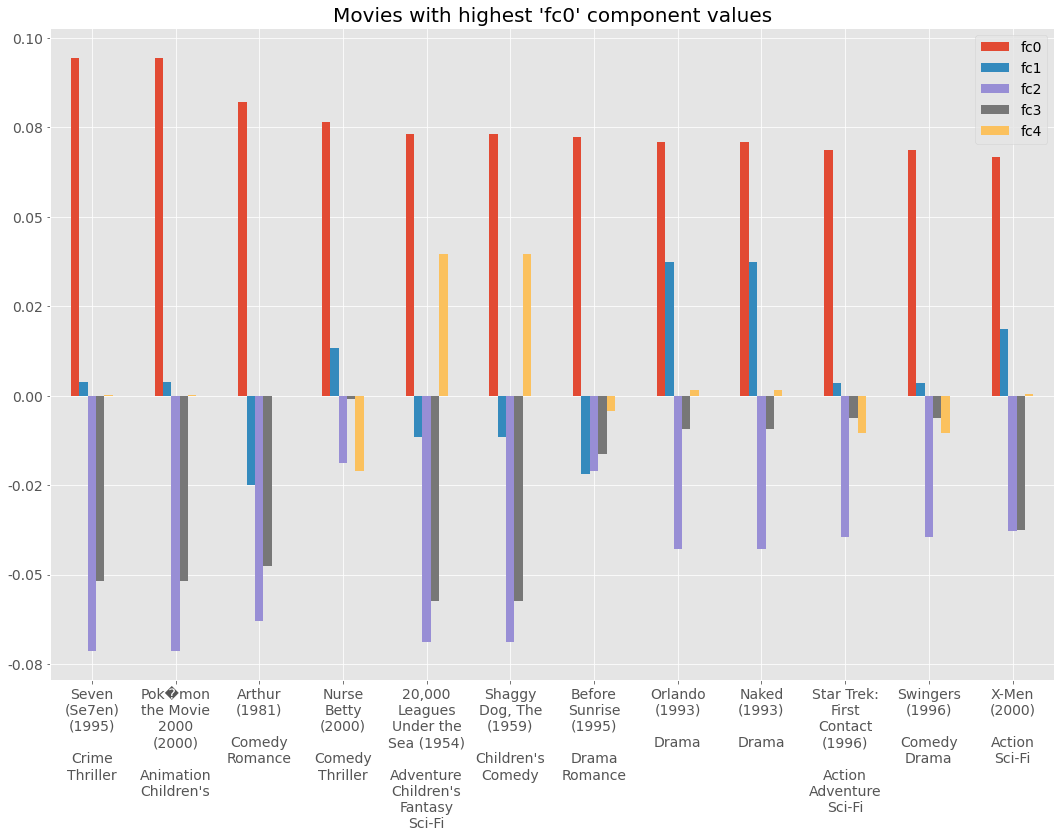

In [64]:
plot_components(components_df, 'fc0', ascending=False)

/opt/anaconda3/envs/followmytv/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


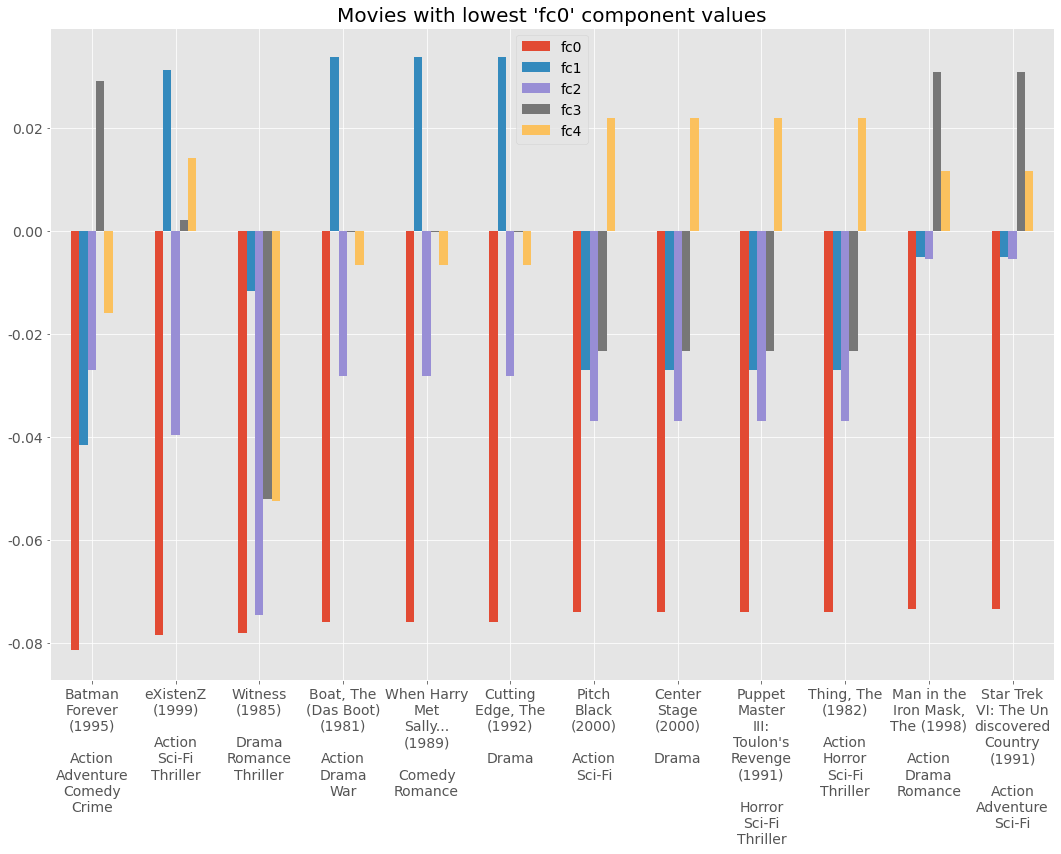

In [65]:
plot_components(components_df, 'fc0', ascending=True)

From the visualizations above, we could make a guess that the red component mostly reflects the rate of "funniness" in the movie. Comedies, animations and adventures mostly have the positives values of this feature while more "dramatical" movies have low levels of this component.